In [1]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, load_statedict, add_lora

args = get_args()
args.arch = 'LeNet5'
args.dataset = 'MNIST'
args.selection_method = 'random'

args.iterations = 5
args.pruning_ratio = 0
args.delta = 1
args.batch_size = 64
args.pruning_strategy = 'random'
args.batch_strategy = 'random'
args.sample_size= 128

# Example Usage

model, target_layers = load_architecture(args)
model.to('cuda')

# statedict = load_statedict(args)
# model.load_state_dict(statedict)
# add_lora(target_layers, model)

# train_dataset = IndexedDataset()
print('init weighted dataset')
train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=4, rank=0, drop_last=True)

print('init dataloder')
trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler,) 

./data
init weighted dataset
60000 60000
init dataloder


In [2]:
from losses import get_loss, get_eval_loss

rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(args.iterations):

    model.train()
    train_sampler.set_epoch(iteration)

    for batch_id, batch in tqdm(enumerate( trainloader ) ):

        optimizer.zero_grad()

        data, target, idxs = batch

        # print(idxs)

        data, target = data.to(rank), target.to(rank) 
         
        loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
        # print(logits_adv.shape)
        # print(logits_nat.shape)
        # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
        assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
        assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

        # train_dataset.update_scores(iteration, idxs,loss_values)
        train_dataset.update_scores(rank, iteration, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)

        loss = train_dataset.compute_loss(idxs, loss_values)
    
        loss.backward()
        optimizer.step()

    indices = train_sampler.process_indices
    # print(train_dataset.global_scores2)
    results = torch.tensor([ train_dataset.decay_model.fit_predict( train_dataset.global_scores2[idx] ) for idx in indices ])
    results = results.float()
    # print(results)
    train_dataset.alphas[indices] = results[:,1]
    train_dataset.betas[indices] = results[:,2]
    train_dataset.cetas[indices] = results[:,3]

    print(loss)

pruning
remove tail
process


0it [00:00, ?it/s]

defaultdict(<class 'list'>, {180: [2.2294108867645264], 116: [2.274007797241211], 172: [2.266334056854248], 244: [2.2943570613861084], 136: [2.4595108032226562], 132: [2.3218722343444824], 124: [2.326225757598877], 160: [2.377152681350708], 104: [2.303943157196045], 248: [2.3128092288970947], 88: [2.1264278888702393], 8: [2.305502414703369], 44: [2.456824779510498], 112: [2.31353497505188], 216: [2.1271512508392334], 16: [2.2517993450164795], 40: [2.3133864402770996], 140: [2.316887617111206], 208: [2.324411630630493], 184: [2.2999649047851562], 120: [2.2460248470306396], 28: [2.241156816482544], 56: [2.101268768310547], 108: [2.139131546020508], 252: [2.255117416381836], 220: [2.249803304672241], 164: [2.3383405208587646], 168: [2.322293281555176], 232: [2.1418538093566895], 72: [2.3240866661071777], 240: [2.3788723945617676], 128: [2.3194262981414795], 60: [2.34525203704834], 20: [2.326380491256714], 64: [2.333529233932495], 80: [2.276578187942505], 224: [2.3411865234375], 32: [2.278

/home/mheuillet/Desktop/robust_training/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(2.32096004486084, 0.1, 0, 1)
1.9002413653928218
(2.2698612213134766, 0.1, 0, 1)
1.8584051871084901
(2.2428672313690186, 0.1, 0, 1)
1.8363043773926846
(2.2826616764068604, 0.1, 0, 1)
1.8688853133468373
(2.1147007942199707, 0.1, 0, 1)
1.731370573786323
(2.2887766361236572, 0.1, 0, 1)
1.8738918189208118
(2.497781276702881, 0.1, 0, 1)
2.0450103456990325
(2.334108352661133, 0.1, 0, 1)
1.911006289339857
(2.2868266105651855, 0.1, 0, 1)
1.872295273026803
(2.2963433265686035, 0.1, 0, 1)
1.8800869010871106
(2.270937919616699, 0.1, 0, 1)
1.8592867131211255
(2.3363006114959717, 0.1, 0, 1)
1.9128011590666463
(2.3086740970611572, 0.1, 0, 1)
1.890182482098511
(2.2775094509124756, 0.1, 0, 1)
1.864667027887792
(2.129026412963867, 0.1, 0, 1)
1.7430993984088212
(2.5167136192321777, 0.1, 0, 1)
2.060510836755574
(2.163085460662842, 0.1, 0, 1)
1.7709845881805217
(2.2387807369232178, 0.1, 0, 1)
1.832958638717625
(2.2441046237945557, 0.1, 0, 1)
1.8373174686250977
(2.2726900577545166, 0.1, 0, 1)
1.86072124249

RuntimeError: Index put requires the source and destination dtypes match, got Float for the destination and Double for the source.

In [7]:
train_sampler.process_indices

[]

In [ ]:
results = torch.tensor([ train_dataset.decay_model.fit_predict( train_dataset.global_scores2[idx] ) for idx in indices ])

In [4]:
train_dataset.global_scores2[0]

[2.364774227142334, 1.091321587562561]

In [4]:
train_dataset.global_scores2   

defaultdict(list,
            {90: [2.3281431198120117,
              0.0043870615772902966,
              0.0007540332153439522,
              0.00025123951490968466,
              0.0002796321641653776],
             58: [2.2430074214935303,
              0.0025242867413908243,
              0.00010647539602359757,
              0.00029433288727886975,
              0.00030639205942861736],
             86: [2.2499005794525146,
              0.20548225939273834,
              0.01787797547876835,
              0.0014113213401287794,
              0.0006145175429992378],
             122: [2.2646923065185547,
              0.06438537687063217,
              0.07532821595668793,
              0.0045533208176493645,
              0.0006375947850756347],
             68: [2.267688751220703,
              0.0014438816579058766,
              3.298623414593749e-05,
              4.419733886606991e-05,
              1.701559995126445e-05],
             66: [2.3393800258636475,
             

torch.Size([5, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

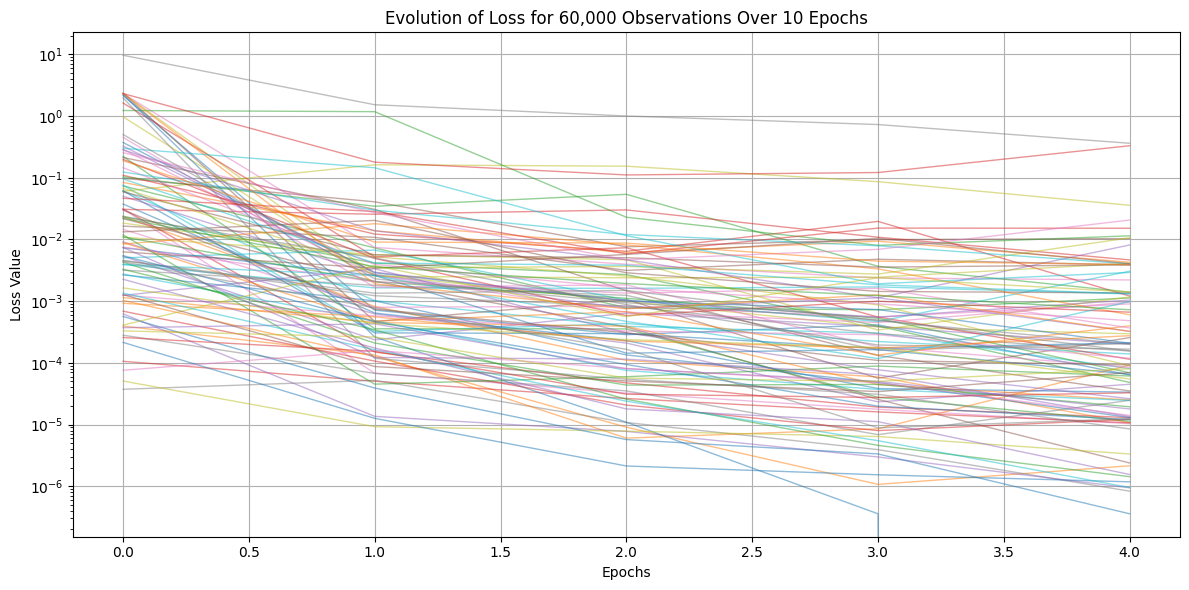

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(args.iterations), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [3]:
observations_losses = train_dataset.global_scores2.T.numpy()

In [1]:
from utils import FitExpDecay

iterations = 10
K = 5
# Initialize global_scores2 with NaNs
global_scores2 = torch.full((iterations, K), float('nan')).cpu()

global_scores2[0][1] = 1
global_scores2[1][1] = 0.5
global_scores2[2][1] = 0.1

global_scores2[0][3] = 10
global_scores2[1][3] = 8
global_scores2[2][3] = 7
global_scores2[3][3] = 4

def get_idx(tensor):
    return torch.nonzero(~torch.isnan(tensor)).view(-1).tolist()

non_nan_indices = torch.nonzero(~torch.isnan(global_scores2[0])).squeeze().view(-1).tolist()
nested_list = [ global_scores2[ get_idx(global_scores2[:,i]), i] for i in non_nan_indices  ]
 
decay_model = FitExpDecay(True)

# results = {idx:decay_model.fit_predict(list) for idx,list in zip(non_nan_indices,nested_list) }
# print("Fitted parameters with c=0:", results)

results = torch.tensor([ decay_model.fit_predict(data) for data in nested_list ])

NameError: name 'torch' is not defined

In [4]:
results[:,0]

tensor([ 1., 10.], dtype=torch.float64)

In [ ]:

# import torch

# non_zero_indices = torch.nonzero(global_scores2[0]).squeeze()
# non_zero_indices = non_zero_indices.view(-1)
# subset_scores = global_scores2[:, non_zero_indices]
# zeros_positions = (subset_scores == 0)
# has_zero = zeros_positions.any(dim=0)
# first_zero_positions = zeros_positions.float().argmax(dim=0)
# first_zero_positions[~has_zero] = subset_scores.shape[0]

# nested_list = [
#     subset_scores[:first_zero_positions[i], i].tolist()
#     for i in range(subset_scores.shape[1])
# ]

# indices_list = non_zero_indices.tolist()

# nested_list

# # Output the results
# print("Non-zero indices in global_scores2:", indices_list)
# print("Nested list of values until zero is encountered for each index:")
# for idx, vals in zip(indices_list, nested_list):
#     print(f"Index {idx}: {vals}")

In [36]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

# Exponential decay function with fixed a and c = 0
def exponential_decay_fixed_a(t, b, a):
    return a * np.exp(-b * t)

# Fit model to data for each observation with a fixed parameter a and c = 0
def fit_exponential_decay_fixed_c_zero(loss_values):
    t = np.arange(len(loss_values))
    a = loss_values[0]  # Fix a as the first loss value
    if len(loss_values) < 3:  # Minimum data length check
        return None  # Not enough data to fit
    # Use curve_fit to estimate only b with c = 0 fixed
    popt, _ = curve_fit(
        lambda t, b: exponential_decay_fixed_a(t, b, a),
        t,
        loss_values,
        p0=(0.1,),        # Initial guess for b
        #bounds=([0], [np.inf])  # Bounds: b >= 0
    )
    return (a, popt[0])  # Return a and b

# Calculate goodness of fit metrics
# def calculate_goodness_of_fit(observed, predicted):
#     # R-squared
#     ss_res = np.sum((observed - predicted) ** 2)
#     ss_tot = np.sum((observed - np.mean(observed)) ** 2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # MSE
#     mse = np.mean((observed - predicted) ** 2)
    
#     # RMSE
#     rmse = np.sqrt(mse)
    
#     # MAE
#     mae = np.mean(np.abs(observed - predicted))
    
#     return r_squared, mse, rmse, mae

# # Example loss values for multiple observations
# observations_losses = [
#     [1.0, 0.8, 0.6, 0.5, 0.4],  # Observation 1
#     [0.9, 0.7, 0.65],           # Observation 2
#     [1.1, 0.95, 0.85, 0.8]      # Observation 3
# ]

# Arrays to store goodness of fit metrics for each observation
# global_r2 = np.zeros(len(observations_losses))
# global_mse = np.zeros(len(observations_losses))
# global_rmse = np.zeros(len(observations_losses))
# global_mae = np.zeros(len(observations_losses))

# # Fit models independently for each observation and calculate goodness of fit
# for idx, loss_values in tqdm(enumerate(observations_losses), total=len(observations_losses)):
#     params = fit_exponential_decay_fixed_c_zero(loss_values)
#     if params:
#         a, b = params
#         t = np.arange(len(loss_values))
#         predicted = exponential_decay_fixed_a(t, b, a)
#         r_squared, mse, rmse, mae = calculate_goodness_of_fit(loss_values, predicted)
#         global_r2[idx] = r_squared
#         global_mse[idx] = mse
#         global_rmse[idx] = rmse
#         global_mae[idx] = mae

# # Display the results
# print("R-squared for each observation:", global_r2)
# print("MSE for each observation:", global_mse)
# print("RMSE for each observation:", global_rmse)
# print("MAE for each observation:", global_mae)


  0%|          | 0/60000 [00:00<?, ?it/s]

/home/mheuillet/Desktop/robust_training/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_6009/1519239995.py:30: RuntimeWarning: invalid value encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
100%|██████████| 60000/60000 [00:16<00:00, 3611.96it/s]

R-squared for each observation: [0.91521045        nan 0.99999989 ...        nan 0.9588786         nan]
MSE for each observation: [3.74383398e-02 0.00000000e+00 5.09324338e-08 ... 0.00000000e+00
 1.32522930e-06 0.00000000e+00]
RMSE for each observation: [0.1934899  0.         0.00022568 ... 0.         0.00115119 0.        ]
MAE for each observation: [0.10037836 0.         0.00016283 ... 0.         0.00083805 0.        ]


In [ ]:

# for i in range(len(train_dataset)):
#     print(train_dataset[i])
import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

